# Stroke graph generated twice...

and then merging methods.

(Also preparing for tests.)

In [1]:
# import libraries
import geopandas as gpd
import momepy
import networkx as nx
from itertools import combinations, product
from shapely import LineString
import numpy as np

* read in gdf of linestrings
* explode
* mm remove false nodes
* mm gdf to nx, primal, preserving index
* mm nx to gdf only of lines
* run coins (pass angle_threshold and flow_mode, defaults!)
* from coins get .stroke_attribute() and .stroke_gdf()
* add "rep_point" to .stroke_gdf()
* add "edge_indeces" column to stroke gdf (anvy version)
* for each edge, add "stroke_id" as attribute to graph (clse version)
* create stroke graph (anvy version)
* add nodes to stroke graph (anvy version)
* adding edges to stroke graph (clse version)
* compute metrics


In [7]:
def _get_interior_angle(a, b):
    '''
    Helper function for ``make_stroke_graph()``.
    Computes interior angle between two LineString segments
    (interpreted as 2-dimensional vectors)

    Parameters
    ----------
    a, b: numpy.ndarray
    '''
    angle = np.rad2deg(np.arccos(np.dot(a, b)/(np.linalg.norm(a) * np.linalg.norm(b))))
    if angle > 90:
        print("over 90")
        angle = 180 - angle
    else:
        print("under 90")
    return angle

def _get_end_segment(linestring, point):
    '''
    Helper function for ``make_stroke_graph()``.
    Returns the first or last two-Point segment of a LineString.

    Parameters
    ----------
    linestring: shapely.LineString
    point: list
        A list of length 2 containing the coordinates of either
        the first or the last point on the linestring.
    '''
    point = tuple(point)
    coords = list(linestring.coords)
    assert point in coords, "point not on linestring!"
    if point == coords[0]:
        geom = [np.array(val) for val in linestring.coords[:2]]
    elif point == coords[-1]:
        geom = [np.array(val) for val in linestring.coords[-2:]]
    else:
        raise ValueError("point is not an endpoint of linestring!")
    return np.array(geom[0] - geom[1])

def make_stroke_graph(gdf, compute_metrics=True, angle_threshold=0, flow_mode=False):
    '''
    Creates the stroke graph of a street network. The stroke graph is similar to, but not identical with,
    the dual graph. In the stroke graph, each stroke (see ``momepy.COINS``) is a node; and each intersection
    between two strokes is an edge.

    Parameters
    ----------
    gdf: GeoDataFrame
        A GeoDataFrame containing edge geometry of a street network.
    compute_metrics: bool (default True)
        if True, computes stroke graph metrics and adds them as node attributes.
        The following metrics are computed: betweenness centrality, closeness centrality, 
        degree, connectivity, access, orthogonality, spacing. # TODO add references here
    angle_threshold: int, float (default 0), units: degrees
        Passed on to ``momepy.COINS()``
     flow_mode : bool, default False
        Passed on to ``momepy.COINS()``
    ''' 

    # remove false nodes (interstitital nodes of degree 2)
    gdf = momepy.remove_false_nodes(gdf)

    # make primal graph
    graph = momepy.gdf_to_nx(
        gdf, 
        preserve_index=True, # !! preserving index needed for unambiguous mapping to coins!
        approach="primal"
    )

    # get momempy lines of graph
    lines = momepy.nx_to_gdf(
        graph,
        points=False,
        lines=True
    )

    # get COINS of graph lines
    coins = momepy.COINS(lines, angle_threshold=angle_threshold, flow_mode=flow_mode)

    # get strokes attributes from coins
    stroke_attribute = coins.stroke_attribute()

    # get strokes gdf fro coins
    stroke_gdf = coins.stroke_gdf()

    # add representative point to stroke_gdf (for later visualization)
    stroke_gdf["rep_point"] = stroke_gdf.geometry.apply(lambda x: x.interpolate(0.5, normalized=True))

    # add stroke_id column
    stroke_gdf["stroke_id"] = stroke_gdf.index

    # add column containing indeces of edges comprising each stroke 
    # (using COINS.stroke_attribute to map into ID defined in lines gdf)
    stroke_gdf["edge_indeces"] = stroke_gdf.stroke_id.apply(
        lambda x: list(stroke_attribute[stroke_attribute==x].index)
    )

    # Add stroke ID to each edge on (primal) graph
    nx.set_edge_attributes(
        G=graph, 
        values={e: int(stroke_attribute[graph.edges[e]["index_position"]]) for e in graph.edges},
        name="stroke_id"
    )

    # make stroke graph
    stroke_graph = nx.Graph()

    # copy crs and approach attributes from "original" primal graph
    stroke_graph.graph["crs"] = graph.graph["crs"]
    stroke_graph.graph["approach"] = graph.graph["approach"]

    # add nodes to stroke graph
    stroke_graph.add_nodes_from(
        [
            (
                row.stroke_id, 
                {
                    "edge_indeces": row.edge_indeces,
                    "geometry": row.rep_point, # "geometry" is the representative point (for viz later)
                    "stroke_geometry": row.geometry,
                    "stroke_length": row.geometry.length,
                    "x": row.rep_point.xy[0][0],
                    "y": row.rep_point.xy[1][0],
                    "connectivity": 0
                }
            ) for _, row in stroke_gdf.iterrows()
        ]
    )

    # add edges to stroke graph
    for n in graph.nodes:
        strokes_present = [graph.edges[e]["stroke_id"] for e in graph.edges(n, keys=True)]
        # If strokes intersecting, add the edge if not already present
        if len(set(strokes_present)) > 1:
            for u, v in combinations(set(strokes_present), 2):
                # Find all edges touching the node for both strokes checked
                edges_u = [e for e in graph.edges(n, keys=True) if graph.edges[e]["stroke_id"] == u]
                edges_v = [e for e in graph.edges(n, keys=True) if graph.edges[e]["stroke_id"] == v]
                angle_list = []
                angle_dict = {}
                # Choose the smallest list as number of angles kept
                chosen, other = sorted([edges_u, edges_v], key=len)
                # Find the angles
                for ce, oe in list(product(chosen, other)):
                    point = [graph.nodes[n]["x"], graph.nodes[n]["y"]]
                    gc = _get_end_segment(graph.edges[ce]["geometry"], point)
                    go = _get_end_segment(graph.edges[oe]["geometry"], point)
                    if ce in angle_dict:
                        print(gc, go)
                        angle_dict[ce].append(_get_interior_angle(gc, go))
                    else:
                        angle_dict[ce]= [_get_interior_angle(gc, go)]
                # Keep the smallest angles
                angle_list = [min(angle_dict[ekey]) for ekey in angle_dict]
                if stroke_graph.has_edge(u, v):
                    stroke_graph.edges[u, v]["angles"] += angle_list
                    stroke_graph.edges[u, v]["number_connections"] = len(stroke_graph.edges[u, v]["angles"])
                else:
                    edge_geometry = LineString(
                        [
                            stroke_graph.nodes[u]["geometry"],
                            stroke_graph.nodes[v]["geometry"]
                        ]
                    )
                    stroke_graph.add_edge(
                        u,
                        v,
                        geometry=edge_geometry,
                        angles=angle_list,
                        number_connections=len(angle_list),
                    )

    # once stroke graph is created, compute metrics
    if compute_metrics:
        
        # add stroke betweenness
        nx.set_node_attributes(
            stroke_graph,
            nx.betweenness_centrality(stroke_graph),
            "stroke_betweenness"
        )

        # add stroke closeness
        nx.set_node_attributes(
            stroke_graph,
            nx.closeness_centrality(stroke_graph),
            "stroke_closeness"
        )

        # add stroke degree
        nx.set_node_attributes(
            stroke_graph,
            dict(nx.degree(stroke_graph)),
            "stroke_degree"
        )

        # add derived metrics
        for n in stroke_graph.nodes:
            stroke_graph.nodes[n]["stroke_connectivity"] = sum([stroke_graph.edges[e]["number_connections"] for e in stroke_graph.edges(n)])
            stroke_graph.nodes[n]["stroke_access"] = stroke_graph.nodes[n]["stroke_connectivity"] - stroke_graph.nodes[n]["stroke_degree"]
            angles = [val for e in stroke_graph.edges(n) if stroke_graph.edges[e]["angles"] for val in stroke_graph.edges[e]["angles"]]
            stroke_graph.nodes[n]["stroke_orthogonality"] = sum(angles) / stroke_graph.nodes[n]["stroke_connectivity"]
            stroke_graph.nodes[n]["stroke_spacing"] = stroke_graph.nodes[n]["stroke_length"] / stroke_graph.nodes[n]["stroke_connectivity"]

    return stroke_graph

In [5]:
# read in toy graph (Bubenec)
gdf = gpd.read_file(momepy.datasets.get_path("bubenec"), layer="streets")

stroke_graph = make_stroke_graph(gdf)

[172.43389124 200.04361864] [-21.00598791  53.213871  ]
[-67.53753506 169.20194522] [ -36.70203611 -143.20022765]
[20.67202944 -5.31082693] [ -36.70203611 -143.20022765]
[138.74861333  50.07089695] [ -36.70203611 -143.20022765]
[-10.17460146 -11.36771275] [-12.85740118  23.9677018 ]
[-12.94645678 -53.64521433] [-12.46778297   2.95038997]
[ -2.52695244 -10.77759593] [-12.46778297   2.95038997]
[14.41587406 -2.08266641] [ 48.81359671 196.04599555]
[-11.4770395    0.83306642] [ 48.81359671 196.04599555]
[-5.34333556 14.05794796] [186.99448064  72.66718594]
[-3.71807099  9.75380008] [186.99448064  72.66718594]
[186.99448064  72.66718594] [-34.82073672  95.5406763 ]
[137.64655037  52.36093896] [-34.82073672  95.5406763 ]
[-103.43807085 -118.06598393] [-56.182947    46.47685819]
[ -43.24762217 -184.31034761] [-17.16546548   4.16515838]
[ -3.33958472 -14.3871424 ] [-17.16546548   4.16515838]
[-113.35663747 -124.5378657 ] [-44.58345606  42.29401113]
[-8.56046884 12.61777878] [23.77784324 90.19

In [22]:
_get_interior_angle([0,1],[3,1])

under 90


np.float64(71.56505117707799)

In [24]:
linestring = LineString([[0,0],[0,1],[0,2],[0,3]])

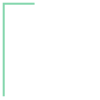

In [30]:
linestring

In [29]:
linestring = LineString(
    [
        [0,0],
        [0,1],
        [0,2],
        [0,3],
        [1,3]
    ]
)

In [32]:
_get_end_segment(linestring, [1,3])

array([-1.,  0.])